## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import sentencepiece as spm
import scienceplots
import pandas as pd
from rdkit import Chem
plt.rcParams.update( {'text.usetex' : True,
                    'font.size' : 14})
plt.style.use(['science','no-latex'])

In [2]:
data_path = os.path.join("Liu_Kheyer_Retrosynthesis_Data")
train_path = os.path.join(data_path, "train")
validation_path = os.path.join(data_path, "validation")
test_path = os.path.join(data_path, "test")
train_reactants_df = pd.read_csv(os.path.join(
    train_path, "train_targets.txt"), header=None)
train_products_df = pd.read_csv(os.path.join(
    train_path, "train_sources.txt"), header=None)

In [3]:
def process_dfs(react_df, prod_df):
    react_df_n = react_df.copy()
    prod_df_n = prod_df.copy()
    prod_df_n.rename(columns={0: "products"}, inplace=True)
    react_df_n.rename(columns={0: "reactants"}, inplace=True)
    prod_df_n["reaction_type"] = prod_df_n["products"].str.extract(
        r"(\<RX_.*\>)")
    prod_df_n["products"] = prod_df_n["products"].str.replace(
        r"(\<RX_.*\>)", "", regex=True)
    df = pd.concat([react_df_n, prod_df_n], axis=1)
    return df


def prepare_whole_reaction_padded(df):
    df["full_input_format_delimited"] = "[BOS]" + \
        df["reactants"]+">>"+df["products"]+"[EOS]"
    df["full_input_format_delimited"] = df["full_input_format_delimited"].str.replace(
        " ", "")
    df["full_input_format"] = df["reactants"].str.replace(
        " ", "")+">>"+df["products"].str.replace(" ", "")


df = process_dfs(train_reactants_df, train_products_df)
prepare_whole_reaction_padded(df)

params = Chem.rdChemReactions.ReactionFingerprintParams()
params.fpSize = 2048
df["rxn"] = df.apply(lambda x: Chem.rdChemReactions.ReactionFromSmarts(
    x["full_input_format"], useSmiles=True), axis=1)
df["fingerprint"] = df.apply(
    lambda x: Chem.rdChemReactions.CreateDifferenceFingerprintForReaction(x["rxn"], params), axis=1)

In [4]:
spt_1 = spm.SentencePieceTrainer.train(
    "--input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1")
sp = spm.SentencePieceProcessor()
sp.load('m.model')
print(sp.get_piece_size())

56


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

Now we can tokenize the training data:

In [5]:
PAD_TOKEN = sp.encode_as_ids("[PAD]")[1]


def tokenize_and_pad(df, max_len=0):
    # choose to set the max_len based on a user entered value or the one derived from the data
    if max_len == 0:
        max_val = df["input_ids"].str.len().sort_values(
            ascending=False).head(1).values[0]
        print(max_val)
        return
    else:
        max_val = max_len
    # Create the encoded columns
    df["input_ids"] = df["full_input_format_delimited"].apply(
        sp.encode_as_ids).apply(lambda x: x[1:])
    df_new = df[df["input_ids"].apply(len) <= max_val].copy()
    print("removed ", df.shape[0]-df_new.shape[0], " samples")

    # calculate how much to pad for each case
    df_new["input_counts"] = max_val-df_new["input_ids"].str.len()

    # pad with the PAD_TOKEN
    df_new["input_ids"] = df_new.apply(lambda row: np.pad(
        row["input_ids"], (0, row["input_counts"]), mode='constant', constant_values=(0, PAD_TOKEN)), axis=1)

    return np.asarray(df_new["input_ids"].values.tolist()), max_val, df_new


train_inputs, train_input_len, df_with_max_200 = tokenize_and_pad(df, 200)
fingerprints = []
for i in df_with_max_200.index:
    array = np.zeros((0, ), dtype=np.float64)
    Chem.DataStructs.ConvertToNumpyArray(
        df_with_max_200.loc[i, "fingerprint"], array)
    fingerprints.append(array)

df_with_max_200["input_ids"].str.len().sort_values(), len(fingerprints)

removed  474  samples


(0        200
 26676    200
 26677    200
 26678    200
 26679    200
         ... 
 13352    200
 13353    200
 13354    200
 13347    200
 40028    200
 Name: input_ids, Length: 39555, dtype: int64,
 39555)

Now let's create the pipeline for validation and test data:

In [6]:
def data_to_Ids_pipeline(reactants_df, products_df, max_len=0):
    dfa = process_dfs(reactants_df, products_df)
    prepare_whole_reaction_padded(dfa)
    inputs, input_len, dfa_new = tokenize_and_pad(dfa, max_len)
    return dfa_new, inputs, input_len


valid_products_df = pd.read_csv(os.path.join(
    validation_path, "valid_sources.txt"), header=None)
valid_reactants_df = pd.read_csv(os.path.join(
    validation_path, "valid_targets.txt"), header=None)

test_products_df = pd.read_csv(os.path.join(
    test_path, "test_sources.txt"), header=None)
test_reactants_df = pd.read_csv(os.path.join(
    test_path, "test_targets.txt"), header=None)
valid_df, valid_inputs, valid_input_len = data_to_Ids_pipeline(
    valid_reactants_df, valid_products_df, max_len=200)

test_df, test_inputs, test_input_len = data_to_Ids_pipeline(
    test_reactants_df, test_products_df, max_len=200)
print("Shape of validation Ids inputs:", valid_inputs.shape)
print("Shape of Test Ids inputs:",  test_inputs.shape)

removed  69  samples
removed  48  samples
Shape of validation Ids inputs: (4935, 200)
Shape of Test Ids inputs: (4956, 200)


## Data Visualization

In [150]:
import numpy as np
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt

reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition"
}

rxn2number = {
    "<RX_10>": 0,
    "<RX_1>": 1,
    "<RX_2>": 2,
    "<RX_3>": 3,
    "<RX_4>": 4,
    "<RX_5>": 5,
    "<RX_6>": 6,
    "<RX_7>": 7,
    "<RX_8>": 8,
    "<RX_9>": 9,
}


def pca_umap_reduction(data, pca_components, plot_variance=False):
    if len(data) == 1:
        data = data[0]
        # Step 1: Perform PCA to reduce to pca_components dimensions
        pca = PCA(n_components=pca_components)
        pca.fit(data)
        pca_result = pca.transform(data)

        # Optionally plot the explained variance
        if plot_variance:
            plt.figure(figsize=(10, 6))
            plt.plot(np.arange(1, pca_components + 1),
                     pca.explained_variance_ratio_, marker='o', linestyle='--')
            plt.title('Explained Variance by PCA Components')
            plt.xlabel('PCA Component')
            plt.ylabel('Explained Variance Ratio')
            plt.xticks(np.arange(1, pca_components + 1))
            plt.grid(True)
            plt.show()

        # Step 2: Perform UMAP to reduce the dimensions further to 2D
        if pca_components > 2:
            umap_reducer = umap.UMAP(n_components=2)
            umap_reducer.fit(pca_result)
            reduced_data = umap_reducer.transform(pca_result)

            return reduced_data
        else:
            return pca_result
    else:
        # Step 1: Perform PCA to reduce to pca_components dimensions
        pca = PCA(n_components=pca_components)
        pca.fit(data[0])
        pca_result_1 = pca.transform(data[0])
        pca_result_2 = pca.transform(data[1])
        pca_result_3 = pca.transform(data[2])

        # Optionally plot the explained variance
        if plot_variance:
            plt.figure(figsize=(10, 6))
            plt.plot(np.arange(1, pca_components + 1),
                     pca.explained_variance_ratio_, marker='o', linestyle='--')
            plt.title('Explained Variance by PCA Components')
            plt.xlabel('PCA Component')
            plt.ylabel('Explained Variance Ratio')
            plt.xticks(np.arange(1, pca_components + 1))
            plt.grid(True)
            plt.show()

        # Step 2: Perform UMAP to reduce the dimensions further to 2D
        if pca_components > 2:
            umap_reducer = umap.UMAP(n_components=2)
            umap_reducer.fit(pca_result_1)
            reduced_data_1 = umap_reducer.transform(pca_result_1)
            reduced_data_2 = umap_reducer.transform(pca_result_2)
            reduced_data_3 = umap_reducer.transform(pca_result_3)

            return reduced_data_1, reduced_data_2, reduced_data_3
        else:
            return pca_result_1, pca_result_2, pca_result_3

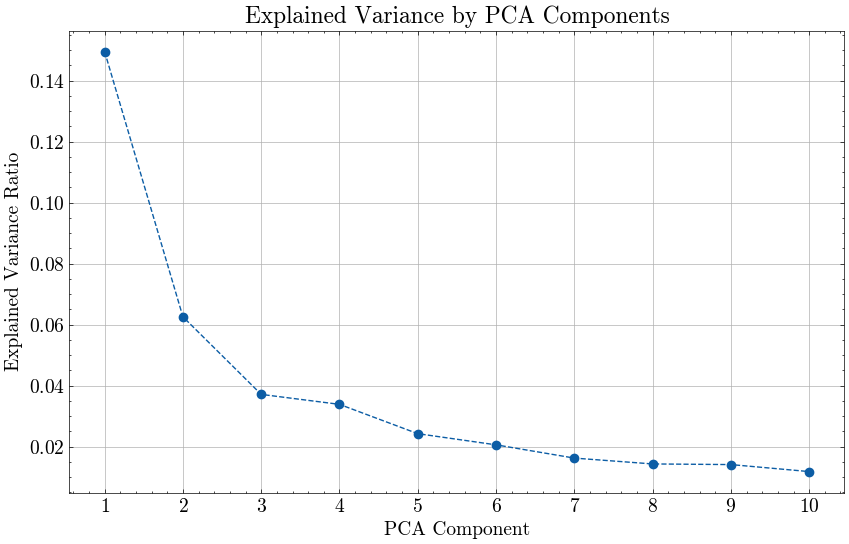

In [65]:
fingerprints_umap2 = pca_umap_reduction(
    [fingerprints], pca_components=10, plot_variance=True)

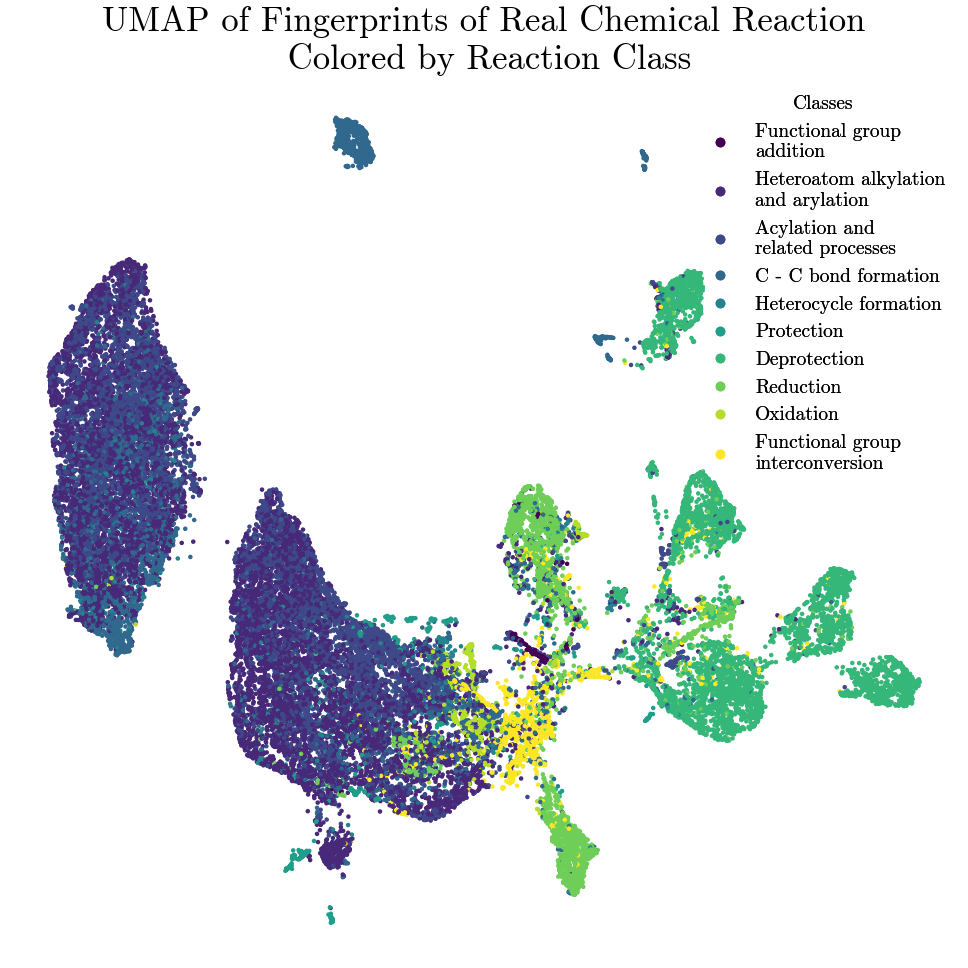

In [151]:
reaction_type_encoded = df_with_max_200["reaction_type"].apply(
    lambda x: rxn2number[x])

# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0], fingerprints_umap2[:, 1], s=5, c=reaction_type_encoded, cmap='viridis')

# Adding the legend with the correct labels
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Real Chemical Reaction\n Colored by Reaction Class", fontsize=25)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/umap_original_colored_by_rxns.svg",
            bbox_inches='tight', dpi=500)

In [75]:
import torch
import random
import json
with open("config.json", 'r', encoding='utf-8') as file:
    config = json.load(file)
    config = {param: value for _, params in config.items()
              for param, value in params.items()}
config["cuda"] = config["cuda"] and torch.cuda.is_available()

# fix seeds
torch.manual_seed(config["seed"])
torch.use_deterministic_algorithms(True)
np.random.seed(config["seed"])
random.seed(config["seed"])
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

if config["cuda"]:
    torch.cuda.manual_seed(config["seed"])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [77]:
from eval import Evaluator
from generate import VAEGenerator
from utils import predict_rxn_type
vae_generator = VAEGenerator(config)
evaluator = Evaluator(config)
# "model_weights/synthesizer/reproduced/v4/vae_epoch76_kl1_warm_up10_aggressiveFalse_loss49.0124.pt"
vae_generator.generate_samples(seed=1000)
evaluator.load_generated_dataset(config["gene_path"])

evaluator.process_results(use_filters=False)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints)
gen_fingerprints_1 = evaluator.gen_fingerprints
rxn_pred_1 = evaluator.rxn_pred

evaluator.process_results(use_filters=True)
evaluator.rxn_pred = predict_rxn_type(
    evaluator.rxn_classifier, evaluator.gen_fingerprints)
gen_fingerprints_2 = evaluator.gen_fingerprints
rxn_pred_2 = evaluator.rxn_pred

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=Liu_Kheyer_Retrosynthesis_Data/vocab2.txt --model_prefix=m  --user_defined_symbols=[BOS],[EOS],[PAD],. --vocab_size=56 --bos_id=-1 --eos_id=-1
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: Liu_Kheyer_Retrosynthesis_Data/vocab2.txt
  input_format: 
  model_prefix: m
  model_type: UNIGRAM
  vocab_size: 56
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: [BOS]
  user_defined_symbols: [EOS]
  user_defined_symbols: [PAD]
  user_defined_symbols: .
  required_cha

In [78]:
len(gen_fingerprints_1), len(gen_fingerprints_2)

(32470, 3846)

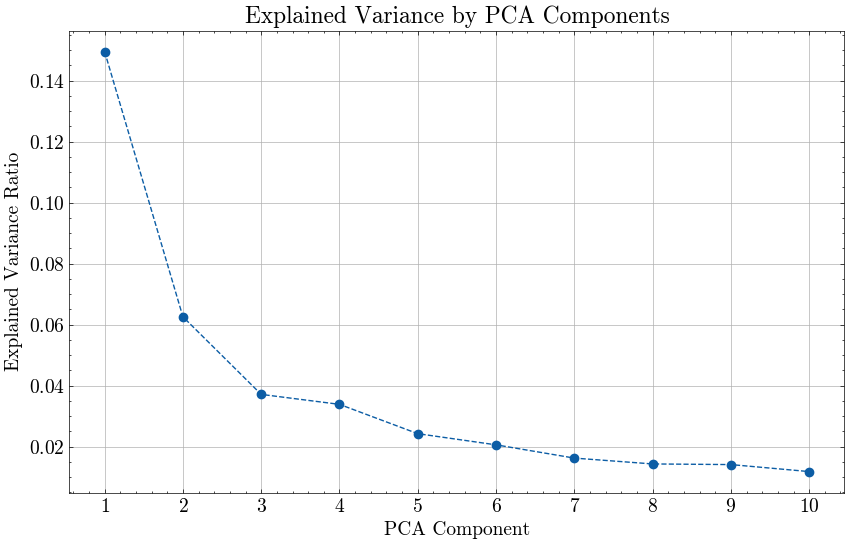

In [90]:
fingerprints_umap2, fingerprints_umap21, fingerprints_umap22 = pca_umap_reduction(
    [fingerprints, gen_fingerprints_1, gen_fingerprints_2], pca_components=10, plot_variance=True)

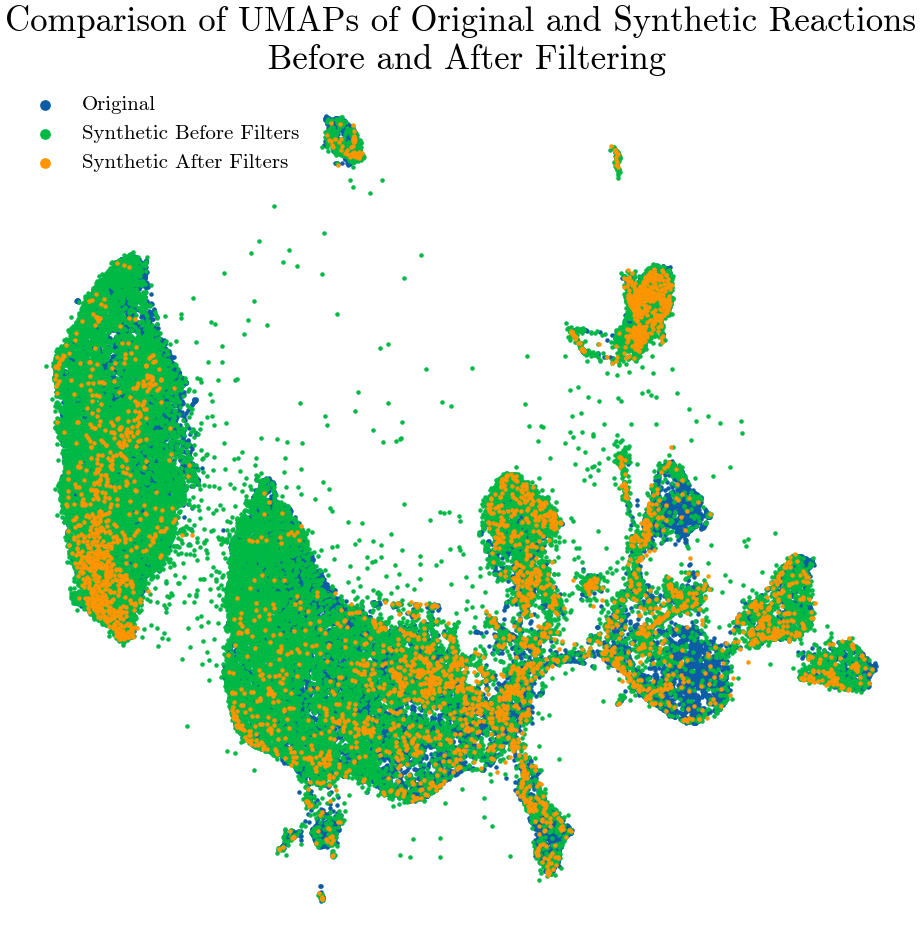

In [91]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap2[:, 0], fingerprints_umap2[:, 1], s=5, label="Original")
scatter = ax.scatter(
    fingerprints_umap21[:, 0], fingerprints_umap21[:, 1], s=5, label="Synthetic Before Filters")
scatter = ax.scatter(
    fingerprints_umap22[:, 0], fingerprints_umap22[:, 1], s=5, label="Synthetic After Filters")


plt.title(
    "Comparison of UMAPs of Original and Synthetic Reactions\n Before and After Filtering", fontsize=25)

plt.tight_layout()
plt.legend(fontsize=15, markerscale=3)
ax.set_axis_off()
# plt.show()
plt.savefig("results/new/rxn_umap_before_after.svg",
            bbox_inches='tight', dpi=500)

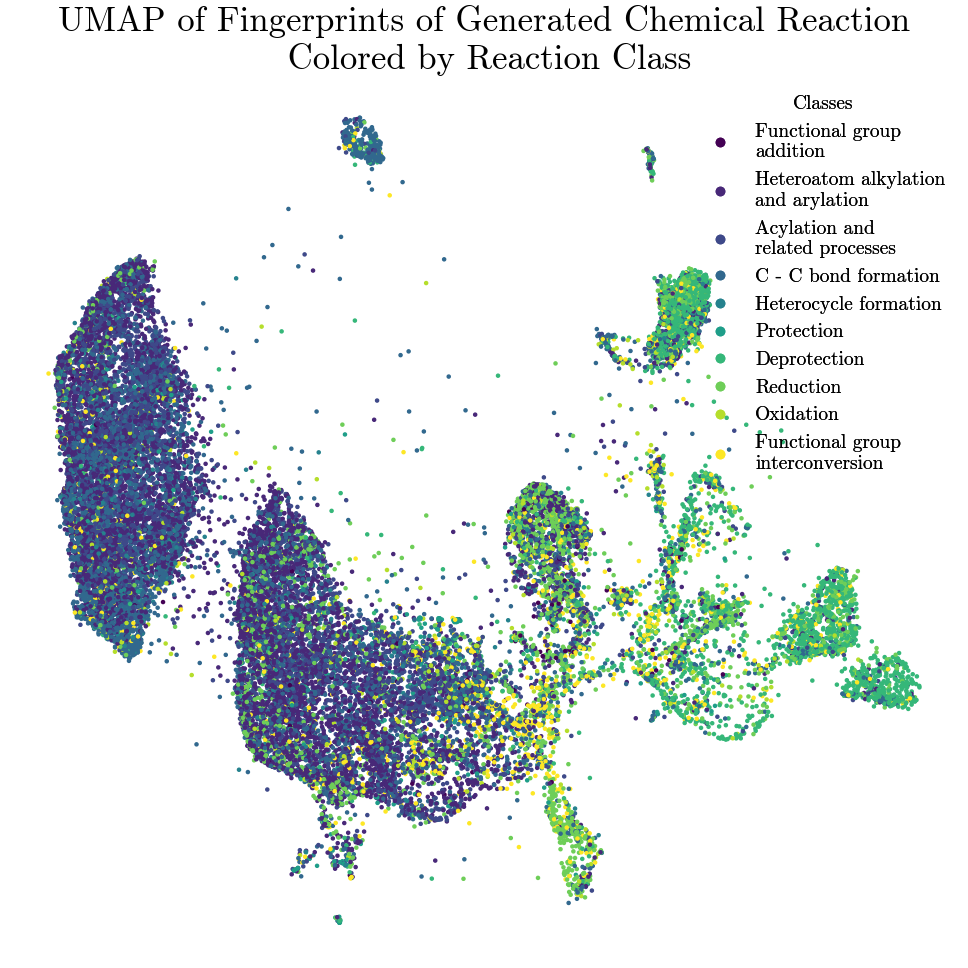

In [152]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap21[:, 0], fingerprints_umap21[:, 1], s=5, c=rxn_pred_1, cmap='viridis')

# Adding the legend with the correct labels
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Generated Chemical Reaction\n Colored by Reaction Class", fontsize=25)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/umap_generated_before_filtering_colored_by_rxns.svg",
            bbox_inches='tight', dpi=500)

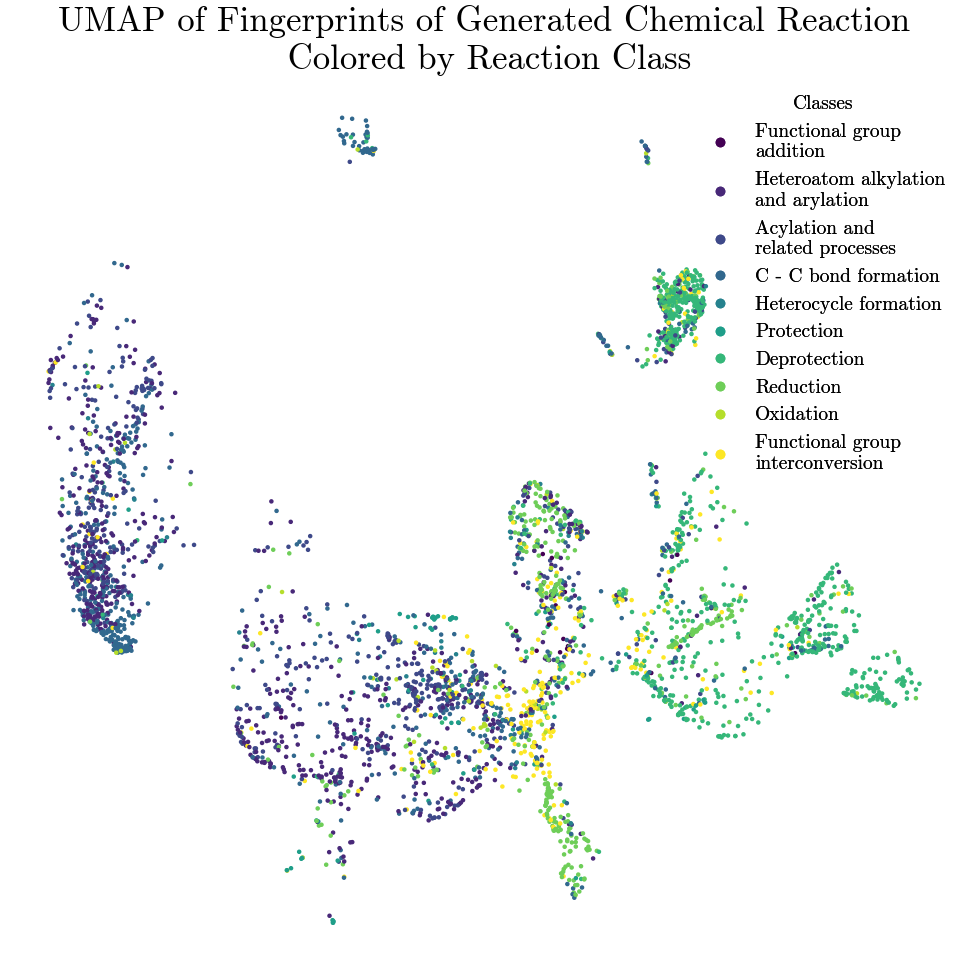

In [157]:
# Step 2: Plotting
plt.rcParams["figure.figsize"] = (10, 10)

fig, ax = plt.subplots()
scatter = ax.scatter(
    fingerprints_umap22[:, 0], fingerprints_umap22[:, 1], s=5, c=rxn_pred_2, cmap='viridis')

# Adding the legend with the correct labels
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
for i, text in enumerate(legend1.get_texts()):
    text.set_text(reaction_data[i])
ax.add_artist(legend1)
ax.set_axis_off()

plt.title(
    "UMAP of Fingerprints of Generated Chemical Reaction\n Colored by Reaction Class", fontsize=25)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/umap_generated_after_filtering_colored_by_rxns.svg",
            bbox_inches='tight', dpi=500)

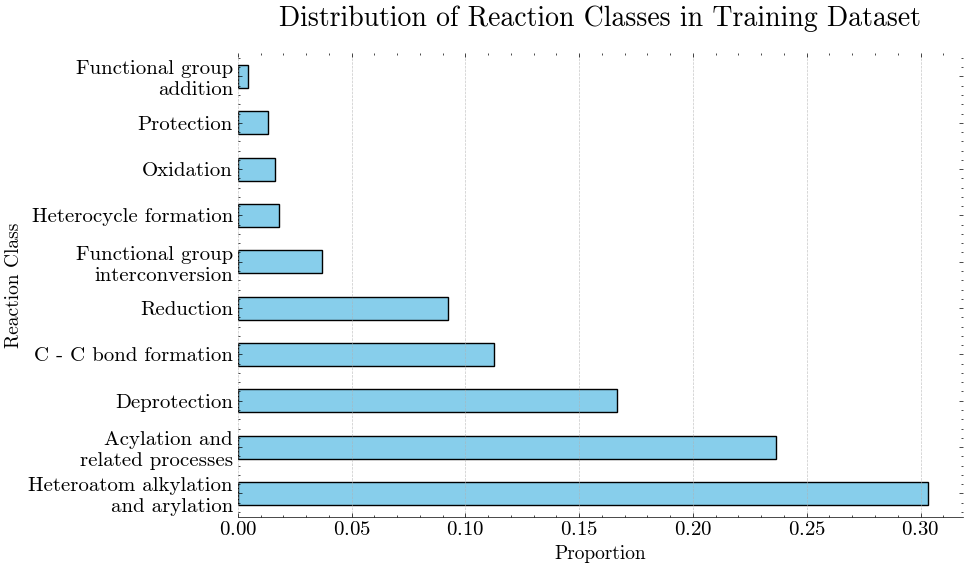

In [153]:
reaction_data = {
    "<RX_1>": "Heteroatom alkylation\nand arylation",
    "<RX_2>": "Acylation and\nrelated processes",
    "<RX_3>": "C - C bond formation",
    "<RX_4>": "Heterocycle formation",
    "<RX_5>": "Protection",
    "<RX_6>": "Deprotection",
    "<RX_7>": "Reduction",
    "<RX_8>": "Oxidation",
    "<RX_9>": "Functional group\ninterconversion",
    "<RX_10>": "Functional group\naddition"
}

# Convert reaction codes to descriptions and calculate the frequency
reaction_counts = df_with_max_200["reaction_type"].apply(
    lambda x: reaction_data[x]).value_counts(normalize=True)

# Plotting
plt.figure(figsize=(10, 6))
reaction_counts.plot(kind='barh', color='skyblue', edgecolor='black')

# Beautify the plot
plt.title('Distribution of Reaction Classes in Training Dataset',
          fontsize=20, weight='bold', pad=20)
plt.xlabel('Proportion', fontsize=14, weight='bold')
plt.ylabel('Reaction Class', fontsize=14, weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Removing the spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
# plt.show()
plt.savefig("results/new/rxn_bar.svg",
            bbox_inches='tight', dpi=500)

In [154]:
valid_df = evaluator.df[evaluator.df["isValid"]].copy()
valid_df["rxn_type"] = rxn_pred_1
valid_df.shape

(32470, 13)

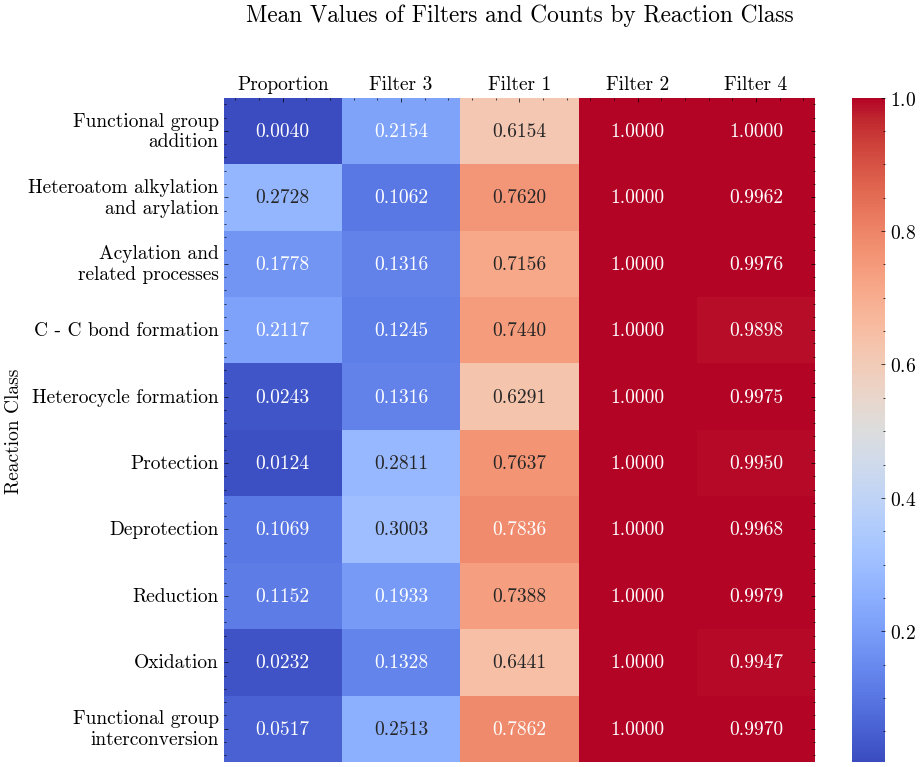

In [161]:
import seaborn as sns
reaction_data = {
    1: "Heteroatom alkylation\nand arylation",
    2: "Acylation and\nrelated processes",
    3: "C - C bond formation",
    4: "Heterocycle formation",
    5: "Protection",
    6: "Deprotection",
    7: "Reduction",
    8: "Oxidation",
    9: "Functional group\ninterconversion",
    0: "Functional group\naddition"
}

heatmap_data = valid_df.groupby("rxn_type")[
    ["Filter_4", "Filter_0", "Filter_2", "Filter_5"]
].mean().join(valid_df["rxn_type"].value_counts(normalize=True).rename("Proportion"))

heatmap_data.index = heatmap_data.index.map(reaction_data)
heatmap_data = heatmap_data.rename(
    {"Filter_4": "Filter 3", "Filter_0": "Filter 1", "Filter_2": "Filter 2", "Filter_5": "Filter 4"}, axis=1)
heatmap_data = heatmap_data[["Proportion",
                             "Filter 3", "Filter 1", "Filter 2", "Filter 4"]]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm',
            fmt=".4f", cbar_kws={'orientation': 'vertical'})

# Move the x-axis ticks to the top
plt.xticks(rotation=45, ha='left')  # Rotate for better readability
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis ticks to the top

# Set the title and labels
plt.title("Mean Values of Filters and Counts by Reaction Class\n", pad=20)
plt.ylabel("Reaction Class")

# Save the plot to a file
plt.tight_layout()
plt.savefig(os.path.join("results/new", "grid_filters_rxntype.svg"),
            bbox_inches='tight', dpi=500)

# Display the plot
plt.show()

## Model Performance

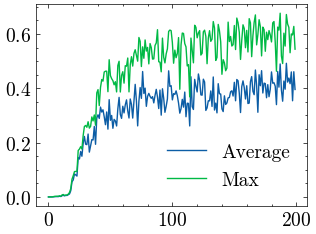

Avg Validity 0.4921 192 Maximum: 0.6717 Std: 0.1444
Max Validity 0.6765 187 Average: 0.4896 Std: 0.1814


In [58]:
import re
import matplotlib.pyplot as plt
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])

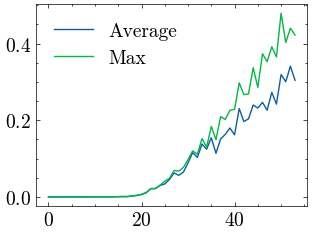

Avg Validity 0.3412 52 Maximum: 0.4401 Std: 0.0909
Max Validity 0.4792 50 Average: 0.3192 Std: 0.1244


In [70]:
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v2.2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "Validity                  (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])

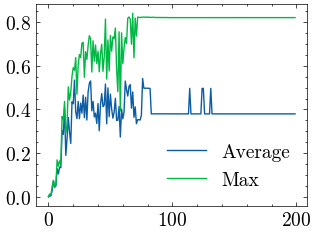

Avg Validity 0.5415 76 Maximum: 0.8204 Std: 0.2494
Max Validity 0.8387 68 Average: 0.4799 Std: 0.2462


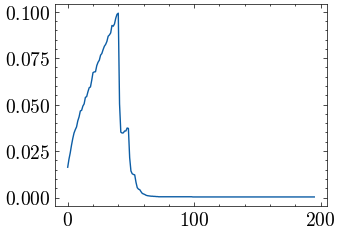

In [67]:
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v4/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "Validity           (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile("epoch: \d+, avg_loss: \d\d.\d\d\d\d, kl: (\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
vals = [float(val) for val in vals]
plt.plot(vals)
plt.show()

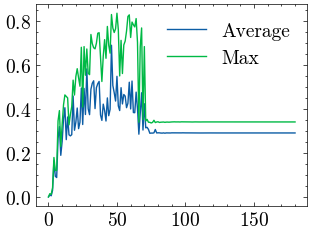

Avg Validity 0.6894 46 Maximum: 0.829 Std: 0.1831
Max Validity 0.835 50 Average: 0.5483 Std: 0.2815


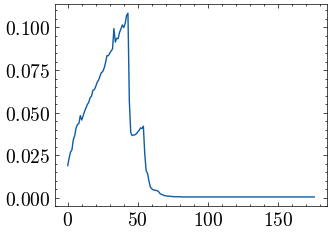

In [60]:
logv2 = "Liu_Kheyer_Retrosynthesis_Data/reproduced/v4.2/train.log"
logv2_str = open(logv2, "r").read()
patt = re.compile(
    "Validity           (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)   (0.\d\d\d\d)")
vals = patt.findall(logv2_str)
avg_vals = [float(val[0]) for val in vals]
max_vals = [float(val[3]) for val in vals]
std_vals = [float(val[1]) for val in vals]
plt.plot(avg_vals, label="Average")
plt.plot(max_vals, label="Max")
plt.legend()
plt.show()
print("Avg Validity", np.max(avg_vals), np.argmax(avg_vals), "Maximum:",
      max_vals[np.argmax(avg_vals)], "Std:", std_vals[np.argmax(avg_vals)])
print("Max Validity", np.max(max_vals), np.argmax(max_vals), "Average:",
      avg_vals[np.argmax(max_vals)], "Std:", std_vals[np.argmax(max_vals)])
patt = re.compile("epoch: \d+, avg_loss: \d\d.\d\d\d\d, kl: (\d.\d\d\d\d)")
vals = patt.findall(logv2_str)
vals = [float(val) for val in vals]
plt.plot(vals)
plt.show()